##Import Libraries

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
import math
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from numpy.random import rand
from numpy.random import seed
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import re
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import Bounds,  minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import random
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import requests
#from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

## Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_row = pd.read_csv('/content/drive/My Drive/loan.csv')

In [ ]:
df_row.shape

(2260668, 145)

#### Pre-Target Distribution

In [ ]:
df_row['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1041952
Current,919695
Charged Off,261655
Late (31-120 days),21897
In Grace Period,8952
Late (16-30 days),3737
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,31


#### Cleaning the Dataset

In [ ]:
df = df_row.loc[:, df_row.isnull().mean() < .8]
#df = df[(df.loan_status != 'In Grace Period')]
df = df.dropna(thresh=int(len(df.columns)*0.5))
colunas_objetos = df.columns[df.dtypes=='object']
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('Sem_Info'))
df.shape

(2257886, 106)

In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1039844
Current,919695
Charged Off,261093
Late (31-120 days),21897
In Grace Period,8952
Late (16-30 days),3737
Does not meet the credit policy. Status:Fully Paid,1912
Does not meet the credit policy. Status:Charged Off,725
Default,31


### Target Definition

Tiramos da base todos que estão em periodo de carência (In grace period) porque n seria possível saber se seriam um bom ou mau pagador. Assumimos todos os que estão com contratos quitados, ou em aberto mas sem faturas vencidas como bons, e os demais clientes, como maus pagadores.

In [ ]:
def get_target(target):
    if target == 'Fully Paid':
        return 0
    #elif target == 'Does not meet the credit policy. Status:Fully Paid':
    #    return 0
    elif target == 'Current':
        return 0
    else:
        return 1

In [ ]:
df['target'] = df['loan_status'].apply(get_target)
df['target'].value_counts(normalize=True,dropna= False)

,proportion
target,
0,0.867864
1,0.132136


In [ ]:
df.shape

(2257886, 107)

## Development Proposed Method (Clustered Spearman-Markowitz)

In [ ]:
print(len(pd.unique(df.issue_d)),'safras mensais')

137 safras mensais


#### Build of Resource Groups (Via Spearman Correlation Coefficient)

In [ ]:
df[colunas_objetos] = df[colunas_objetos].apply(lambda x: x.astype('category').cat.codes)
target = 'target'
safra = 'issue_d'
variaveis = df.columns.drop([target,safra])
correlacoes_p = []
correlacoes_s = []

for COLUNA in variaveis:
  correlacoes_p.append(np.round(df[target].corr(df[COLUNA]),2))
  correlacao, p = spearmanr(df[target], df[COLUNA])
  correlacoes_s.append(np.round(correlacao,2))
df_cor = pd.DataFrame({'Variaveis': variaveis, 'Correlacoes_S': correlacoes_s, 'Correlacoes_P': correlacoes_p})

In [ ]:
df_cor.sort_values(by=['Correlacoes_S'])

,Variaveis,Correlacoes_S,Correlacoes_P
13,loan_status,-0.49,-0.35
34,total_rec_prncp,-0.24,-0.22
30,out_prncp,-0.23,-0.16
31,out_prncp_inv,-0.23,-0.16
40,last_pymnt_amnt,-0.20,-0.19
...,...,...,...
41,next_pymnt_d,0.24,0.23
104,debt_settlement_flag,0.31,0.31
38,collection_recovery_fee,0.73,0.46
37,recoveries,0.75,0.48


In [ ]:
df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].max(),df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].min()


(0.75, -0.49)

#### Distribution of groups based on Spearman Correlation similarity

In [ ]:
df_cor = df_cor.dropna()
df_cor['fx']= pd.qcut(df_cor['Correlacoes_P'], q=4)

lista_variaveis_fx = []
for i in list((range(0,len(pd.unique(df_cor['fx']))))):
  lista_variaveis_fx.append(df_cor[df_cor['fx']==pd.unique(df_cor['fx'])[i]].Variaveis)


tamanho_dos_grupos=[]
lista_de_grupos=[]
lista_variaveis_fx[0]
for i in list(range(0,len(lista_variaveis_fx))):
  lista_de_grupos.append('Grupo '+str(i))
  tamanho_dos_grupos.append(len(lista_variaveis_fx[i]))

divisao_grupos = pd.DataFrame({'Grupos':lista_de_grupos,'Tamanho do Grupo':tamanho_dos_grupos})
divisao_grupos


,Grupos,Tamanho do Grupo
0,Grupo 0,13
1,Grupo 1,25
2,Grupo 2,38
3,Grupo 3,28


#### Number of Selected Predictor Variables:

In [ ]:
divisao_grupos['Tamanho do Grupo'].sum()

104

## Weigh the participation (importance) of each Resource Group in model training (By Markowitz's Theory)

In [ ]:
y = df['target']
X_vetor = []
X_vetor_train = []
X_vetor_test = []
y_vetor_train = []
y_vetor_test = []
for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor.append('X_'+str(i+1))
  X_vetor_train.append('X_train_'+str(i+1))
  X_vetor_test.append('X_test_'+str(i+1))
  y_vetor_train.append('y_train_'+str(i+1))
  y_vetor_test.append('y_test_'+str(i+1))

for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor[i] = df[lista_variaveis_fx[i]]
  X_vetor_train[i], X_vetor_test[i],y_vetor_train[i], y_vetor_test[i]= train_test_split(X_vetor[i], y, test_size = 0.3)

retorno_grupo = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[0]
  df_x[safra]=df[safra]
  df_x[target]=df[target]
  clf = lgb.LGBMClassifier()
  retorno_safra = []
  id_safra = []
  for ANO in pd.unique(df_x[safra]):
    df_xx = df_x[df_x[safra]==ANO]
    x_filtrado = df_xx.drop([safra,target], axis = 1)
    y_filtrado = df_xx.target
    x_filtrado_train, x_filtrado_test, y_filtrado_train, y_filtrado_test= train_test_split(x_filtrado, y_filtrado, test_size = 0.3)
    clf.fit(x_filtrado_train, y_filtrado_train)
    pred_filtrado =clf.predict(x_filtrado_test)
    retorno_safra.append(accuracy_score(pred_filtrado, y_filtrado_test))
    id_safra.append(ANO)
  df_retornos = pd.DataFrame({'Retorno Grupo '+str(i): retorno_safra, 'Safra': id_safra})
  retorno_grupo.append(df_retornos)
df_retornos = reduce(lambda  left,right: pd.merge(left,right,on=['Safra'],how='outer'), retorno_grupo)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [ ]:
first_column = df_retornos.pop('Safra')
df_retornos.insert(0, 'Safra', first_column)
df_retornos


,Safra,Retorno Grupo 0,Retorno Grupo 1,Retorno Grupo 2,Retorno Grupo 3
0,34,0.994187,0.993854,0.993605,0.995266
1,112,0.990311,0.990470,0.990470,0.990391
2,124,0.988699,0.987619,0.987907,0.987403
3,136,0.978476,0.980184,0.980526,0.979330
4,22,0.976635,0.978877,0.977214,0.976780
...,...,...,...,...,...
132,125,0.666667,0.933333,0.866667,0.600000
133,11,0.625000,0.500000,0.625000,0.375000
134,33,0.917184,0.918057,0.913078,0.915000
135,111,0.915374,0.912383,0.912304,0.920098


## Build of efficient Frontier (Risk vs Return). Where, the risk is the variability of accuracy.

In [ ]:
#Cálculo do retorno do portifolio
def get_portfolio_returns(returns, weights):
    return np.dot(returns.mean(), weights)
#Cálculo do risco do portifólio, considerando o desvio padrão
def get_portfolio_risk(returns, weights):
    covariances = returns.cov()
    var_risk = np.matmul(np.matmul((weights), covariances.values), weights)
    std_risk = np.sqrt(var_risk)
    return std_risk
def mount_portfolio(x , args):
    return get_portfolio_risk(args, x)
def compute_frontier(returns_range, returns_df):
    optimal_portfolios = []
    #restrição para que a soma dos pesos não ultrapasse o valor 1
    eq_constraint_proportions = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
    #definição dos limites inferior e superior dos pesos em 0 e 1, respectivamente
    bounds = Bounds(ub=[1,1,1,1], lb=[0,0,0,0])


    #ponto de paprtida para o algoritmo de otimização, foram utilizados pesos igualmente distribuídos
    initial_guess = np.ones(len(returns_df.columns))*1/len(returns_df.columns)
    for value in returns_range:
        #restrição para garantir que o valor de retorno desejado será mantido
        eq_constraint_return = {'type':'eq', 'fun': lambda x : get_portfolio_returns(returns_df, x) - value}

        optimal_weights = minimize(mount_portfolio, x0 = initial_guess, method = 'SLSQP',
                constraints = [eq_constraint_proportions, eq_constraint_return],
                bounds=bounds,  options={'ftol':1e-9, 'disp':False},
                args = (returns_df,))
        optimal_portfolios.append(optimal_weights)

    return optimal_portfolios

In [ ]:
#Definição dos patamares de retorno máximo e mínimo
real_returns = df_retornos.drop(['Safra'],axis=1)
min_return = real_returns.mean().min()
max_return = real_returns.mean().max()
def generate_random_portfolios(num_samples, returns):
    returns_from_random_weights = []
    risks_from_random_weights = []
    weights = []
    for i in range(0, num_samples):
        random_weights = np.random.rand(len(returns.columns))
        random_weights = random_weights/np.sum(random_weights)
        weights.append(random_weights)

        random_return = get_portfolio_returns(returns, random_weights)
        random_risk = get_portfolio_risk(returns, random_weights)

        returns_from_random_weights.append(random_return)
        risks_from_random_weights.append(random_risk)
    return [risks_from_random_weights, returns_from_random_weights, weights]

Text(0.5, 0, 'Risco')

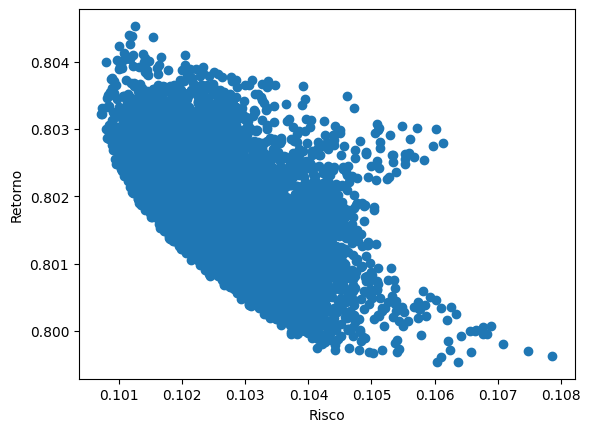

In [ ]:
random_ports = generate_random_portfolios(10000, real_returns)
plt.scatter(random_ports[0], random_ports[1])
plt.ylabel('Retorno')
plt.xlabel('Risco')

### Optimal Risk-Return Binomial (note: Minimum variability criterion, or minimum risk)

In [ ]:
fronteira_eficiente = pd.DataFrame({'Risco':random_ports[0],'Retorno':random_ports[1], 'Pesos':random_ports[2]})
fronteira_eficiente['Pesos'] = fronteira_eficiente.Pesos.apply(lambda x: np.round(x, 2))

In [ ]:
alocacao_otima = fronteira_eficiente[fronteira_eficiente.Risco ==fronteira_eficiente.Risco.min()]
alocacao_otima[['Risco','Retorno']]


,Risco,Retorno
993,0.100718,0.803223


In [ ]:
alocacao_otima.Pesos

,Pesos
993,"[0.26, 0.0, 0.68, 0.06]"


In [ ]:
divisao_grupos['Alocacao Otima'] = alocacao_otima.Pesos.values[0]
divisao_grupos['Tamanho Final do Grupo'] = round((divisao_grupos['Tamanho do Grupo']*divisao_grupos['Alocacao Otima'])/divisao_grupos['Alocacao Otima'].sum(),0)
divisao_grupos

,Grupos,Tamanho do Grupo,Alocacao Otima,Tamanho Final do Grupo
0,Grupo 0,13,0.26,3.0
1,Grupo 1,25,0.00,0.0
2,Grupo 2,38,0.68,26.0
3,Grupo 3,28,0.06,2.0


In [ ]:
print('Número final de váriaveis: ',divisao_grupos['Tamanho Final do Grupo'].sum()),
print('Isso equivale à ',100*(round(1 -(divisao_grupos['Tamanho Final do Grupo'].sum()/divisao_grupos['Tamanho do Grupo'].sum()),2)),'% de redução no volume das variáveis inicias')


Número final de váriaveis:  31.0
Isso equivale à  70.0 % de redução no volume das variáveis inicias


## Building Final Model by LGBM after Feature Selection.

In [ ]:
variaveis_filtradas_csm = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[i]
  df_x = df_x.drop(['safra','target'],axis=1,errors='ignore')
  df_x = df_x.sample(n=int(divisao_grupos['Tamanho Final do Grupo'][i]),axis='columns')
  #df_x = df_x.sample(n=math.ceil(divisao_grupos['Alocacao Otima'][i]*df_x.shape[1]),axis='columns')
  variaveis_filtradas_csm.extend(df_x.columns)

param_grid = {
"num_leaves": [31, 63, 127],
"max_depth": [-1, 3, 9],
"subsample": [0.4, 1.0],
"colsample_bytree": [0.7, 1.0]
}


X_train_final, X_test_final,y_train_final, y_test_final= train_test_split(df[variaveis_filtradas_csm], df[target], test_size = 0.3)
scaler = MinMaxScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)


clf = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=42)
grid = GridSearchCV(clf, param_grid, cv=10, scoring="accuracy")
grid.fit(X_train_final, y_train_final)
predicao = grid.predict(X_test_final)


acuracia_CSM_model = accuracy_score(predicao, y_test_final)
print(len(variaveis_filtradas_csm), "variaveis",  "; acuracia:", acuracia_CSM_model)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [ ]:
acuracia = np.round(acuracia_CSM_model,4)*100
f1_score = (np.round(f1_score(predicao, y_test_final,average='weighted'),5)*100)
precisao = (np.round(precision_score(predicao, y_test_final, average='weighted'),5)*100)
recall = (np.round(recall_score(predicao, y_test_final,average='macro'),4)*100)

In [ ]:
resumo = pd.DataFrame({'Accuracy':[acuracia],
                       'F1 Score': [f1_score],
                       'Precision':[precisao],
                       'Recall':[recall]},index=[0])


# Summary Final Model Performance

In [ ]:
resumo

,Accuracy,F1 Score,Precision,Recall
0,96.8,94.93,99.7,93.4




---

